In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


In [85]:
#df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data_Population_Normalized.csv")
df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

In [86]:
print(df.columns)
print(df.shape)

Index(['week_no', 'iso_code', 'new_cases', 'new_deaths', 'new_vaccinations',
       'new_people_vaccinated', 'reproduction_rate', 'stringency_index',
       'excess_mortality', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population'],
      dtype='object')
(41184, 21)


In [87]:

df.drop(["iso_code", "week_no"], axis=1, inplace=True)
#df.drop(columns=df.columns[0:1], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[234*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41183, dtype: float64


In [88]:
# now we want to join datas together
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []

for i in range(234):  # 234 is number of countries
    for j in range(176):  # 176 is number of weeks we have
        row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
        features_list.append(row_list)

for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])


In [89]:
print(len(X_list))
print(len(Y_list))
np.shape(X_list)

40950
40950


(40950, 38)

In [90]:
# Here we are going to normalize the data.
from sklearn import preprocessing
x_df = pd.DataFrame(X_list)
min_max_scaler_X = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_X.fit_transform(x_df)

y_df = pd.DataFrame(Y_list)
min_max_scaler_Y = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_Y.fit_transform(y_df)

X_scaled_list = x_scaled.tolist()
Y_scaled_list = y_scaled.tolist()

#df = pd.DataFrame(x_scaled)

In [91]:
import math

def train_test_splitter(X, Y, prediction_days_count, batch_count, batch_length):
    xlen = len(X)
    xs_count_for_each_country = int(xlen / 234)
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
    i = 0
    for i in range(234):
        j = 0
        for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
            X_train.append(X[j])
            Y_train.append(Y[j])
        while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
            for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                X_test.append(X[k])
                Y_test.append(Y[k])
            j += batch_length
            for k in range(j, j + steps):
                X_train.append(X[k])
                Y_train.append(Y[k])
            j += steps + 1
            while j < (i+1) * xs_count_for_each_country:
                X_train.append(X[j])
                Y_train.append(Y[j])
                j += 1
    return X_train, X_test, Y_train, Y_test
        

In [92]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_scaled_list, Y_scaled_list, prediction_days_count, 3, 10)

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [94]:
print("X_train:", np.shape(X_train),
      ",X_val:" , np.shape(X_val),
      ",X_test:", np.shape(X_test),

      ",Y_train:" ,np.shape(Y_train),
      ",Y_val:", np.shape(Y_val),
      ",Y_test:", np.shape(Y_test)
      )

X_train: (30888, 38) ,X_val: (7722, 38) ,X_test: (1404, 38) ,Y_train: (30888, 1) ,Y_val: (7722, 1) ,Y_test: (1404, 1)


In [95]:
X_tr = np.array(X_train)
y_tr = np.array(Y_train).reshape(len(Y_train))
X_te = np.array(X_test)
y_te = np.array(Y_test).reshape(len(Y_test))
X_val = np.array(X_val)
y_val = np.array(Y_val).reshape(len(Y_val))

In [96]:
print("X_train:", np.shape(X_tr),
      ",X_val:" , np.shape(X_val),
      ",X_test:", np.shape(X_te),

      ",Y_train:" ,np.shape(y_tr),
      ",Y_val:", np.shape(y_val),
      ",Y_test:", np.shape(y_te)
      )

X_train: (30888, 38) ,X_val: (7722, 38) ,X_test: (1404, 38) ,Y_train: (30888,) ,Y_val: (7722,) ,Y_test: (1404,)


In [97]:
# Rescale predictions and true values back to original scale
def rescale_data(scaler, data):
    return scaler.inverse_transform(np.array(data).reshape(-1, 1)).flatten()

# Loss functions

In [98]:
def mean_square_error_sqrt (y_test, y_pred):
    return np.sqrt((np.sum(np.power(y_test - y_pred, 2)))/len(y_test))
def mean_absolute_error_self_defined (y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

# Modelling

## Importing loss functions

In [99]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error, d2_tweedie_score

## Model Evaluation

In [140]:
def plot_model(y_pred, y_test_rescaled, model_name, ax):
    ax.plot(np.arange(len(y_pred)), y_pred, label='Predicted')
    ax.plot(np.arange(len(y_pred)), y_test_rescaled, alpha=0.6, label='True')
    ax.set_title(f"{model_name} Predictions vs True Values")
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.legend()

In [137]:


def evaluate_model(model, X_train, y_train, X_test, y_test, scaler, model_name, monitoring = True):
    y_pred_scaled = model.fit(X_train, y_train).predict(X_test)
    y_pred = rescale_data(scaler, y_pred_scaled)
    y_test_rescaled = rescale_data(scaler, y_test)

    # deviding by 10:
    y_pred /= 10
    y_test_rescaled /= 10

    # mae = mean_absolute_error_self_defined (y_test, y_pred_scaled)
    # mse = mean_square_error_sqrt(y_test, y_pred_scaled)
    
    mae = mean_absolute_error_self_defined (y_test_rescaled, y_pred)
    mse = mean_square_error_sqrt(y_test_rescaled, y_pred)
    # mape = mean_absolute_percentage_error(y_test_rescaled, y_pred)
    # rmse = mean_squared_error(y_test_rescaled, y_pred, squared=False)


    if monitoring ==True:
        print(f"Evaluating {model_name}")
        print(f"MAE: {mae}")
        print(f"MSE: {mse}")
        # print(f"MAPE: {mape}")
        # print(f"RMSE: {rmse}")
        # print(y_test_rescaled.type)
        # print()
        # print("Y_test:")
        # print(y_test_rescaled[:10])
        # print("Y_pred:")
        print(y_pred[:10])
        fig, axs = plt.subplots(1, 1, figsize=(18, 6))
        
        #plotting data
        plot_model(y_pred , y_test_rescaled , model_name , axs)
    else:
        return mae , mse , y_pred, y_test_rescaled

## SVR

In [144]:
from sklearn.svm import SVR

Evaluating SVR (rbf)
MAE: 2222.7981268369685
MSE: 2598.45391434201
[3475.66972329 3441.32098971 3357.60160067 3301.34029397 3311.66468725
 3261.30333657  667.25243599  266.08050446  398.62776806  434.00402807]


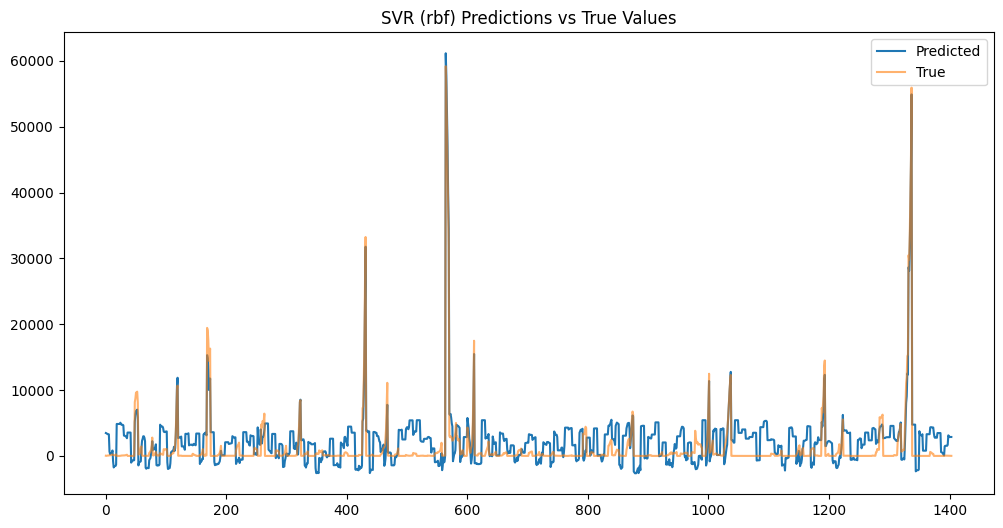

Evaluating SVR (linear)
MAE: 365248.40803274943
MSE: 365835.1298680434
[355590.5997575  355696.36737183 356064.84680167 356200.25287563
 356203.92141833 356417.07486172 354095.5227114  354109.2828579
 354137.35453887 354140.31549481]


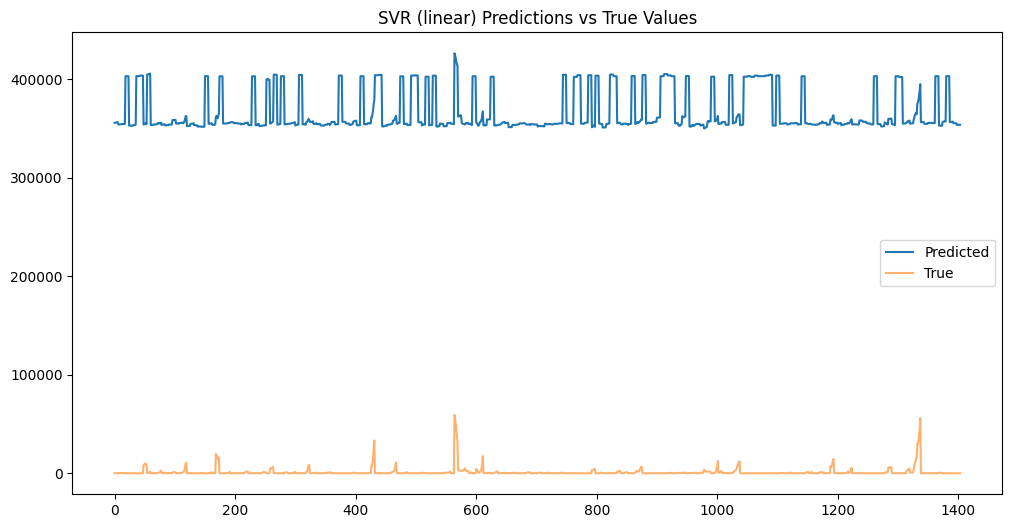

Evaluating SVR (poly)
MAE: 373987.7110878953
MSE: 374399.6195399087
[368509.76669831 368598.27397456 368906.87690599 369024.31328994
 369027.9429175  369207.72026457 362492.18148584 362503.9415021
 362529.47947208 362533.11608665]


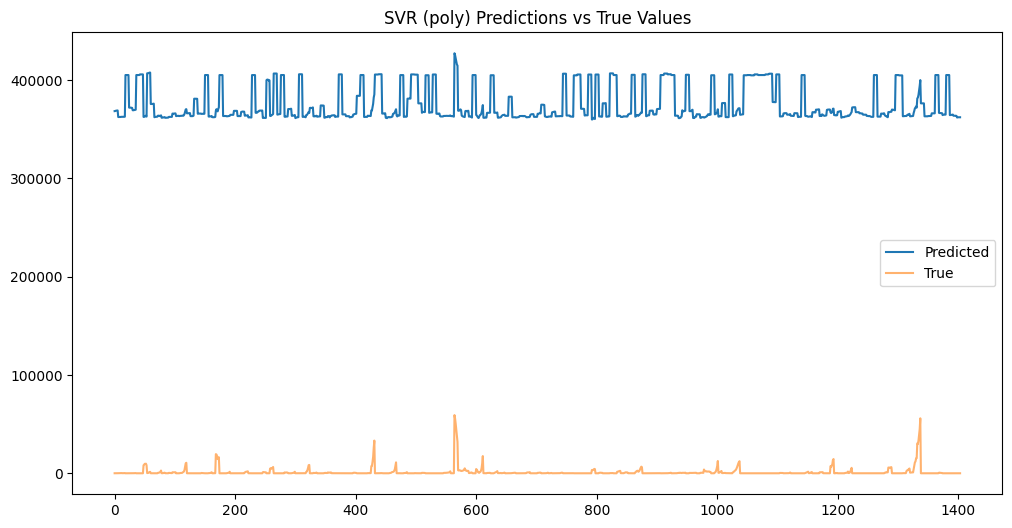

In [145]:
# Train and evaluate SVR models
svrs = [SVR(kernel="rbf", C=50, gamma=0.9, epsilon=0.001),
        SVR(kernel="linear", C=100, gamma="auto"),
        SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)]

for svr in svrs:
    evaluate_model(svr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name=f"SVR ({svr.kernel})")
    #evaluate_model(svr, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name=f"SVR ({svr.kernel})")


## KNN

In [101]:
from sklearn.neighbors import KNeighborsRegressor

Evaluating KNeighborsRegressor
MAE: 506.68162393162385
MSE: 1788.2716983816822
[ 16.85  28.65  92.45  13.75  13.75  22.65 208.95 133.1  386.7  386.7 ]


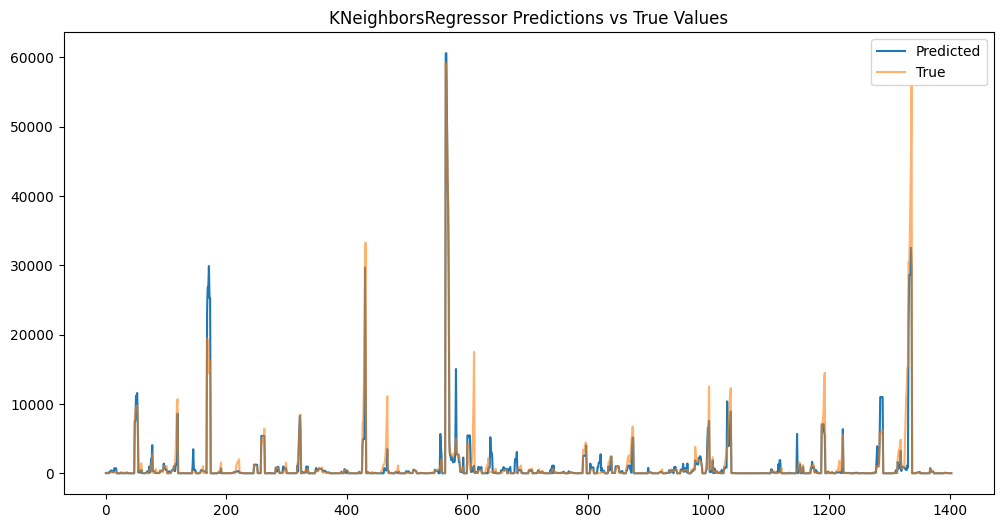

In [102]:
# Train and evaluate KNeighborsRegressor model
neigh = KNeighborsRegressor(n_neighbors=2, p=2)
evaluate_model(neigh, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="KNeighborsRegressor")
#evaluate_model(neigh, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name="KNeighborsRegressor")


### Tuning

In [150]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

ks = [2, 5, 10, 15]
ps = [1,2,3 ]
results = []

for p in ps:
    for k in ks:

        neigh = KNeighborsRegressor(n_neighbors=k, p=p)
        model_err_pred = evaluate_model(neigh, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="KNeighborsRegressor", monitoring=False)
        
        # Append the results along with the k and p values
        results.append((k, p) + model_err_pred)
    
    #logging
    print(f"proccess for p = {p} done.", '\n')

# Convert the list of results to a DataFrame
columns = ["k", "p", "MAE", "MSE", "y_pred", "y_test_rescaled"]
tuning_data_df = pd.DataFrame(results, columns=columns)


proccess for p = 1 done. 

proccess for p = 2 done. 

proccess for p = 3 done. 



In [121]:
tuning_data_df

,k,p,MAE,MSE,y_pred,y_test_rescaled
0,2,1,495.767379,1944.471611,"[16.85, 16.85, 92.44999999999999, 13.75, 13.75...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
1,5,1,498.920228,1972.475257,"[27.880000000000003, 27.880000000000003, 48.42...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
2,10,1,546.419537,2165.101107,"[64.02, 64.02, 65.66999999999999, 67.53, 67.53...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
3,15,1,552.039345,2279.025710,"[50.16000000000001, 50.94666666666667, 78.1, 8...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
4,2,2,506.681624,1788.271698,"[16.85, 28.649999999999995, 92.44999999999999,...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
5,5,2,505.484003,1863.571038,"[27.880000000000003, 54.8, 168.06, 25.84000000...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
6,10,2,526.650285,1975.007954,"[64.02, 64.02000000000001, 147.85999999999999,...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
7,15,2,549.394103,2144.787659,"[54.02666666666668, 53.506666666666675, 126.02...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
8,2,3,528.940313,1810.290187,"[16.85, 28.649999999999995, 26.2, 13.75, 13.75...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
9,5,3,535.974558,1910.636381,"[27.880000000000003, 54.8, 168.06, 25.84000000...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."


for k=2 , p=1: MAE = 495.76737891737884 , MSE = 1944.4716113108288
for k=2 , p=2: MAE = 506.68162393162385 , MSE = 1788.2716983816822
for k=10 , p=3: MAE = 555.2186253561254 , MSE = 2015.9567347395648


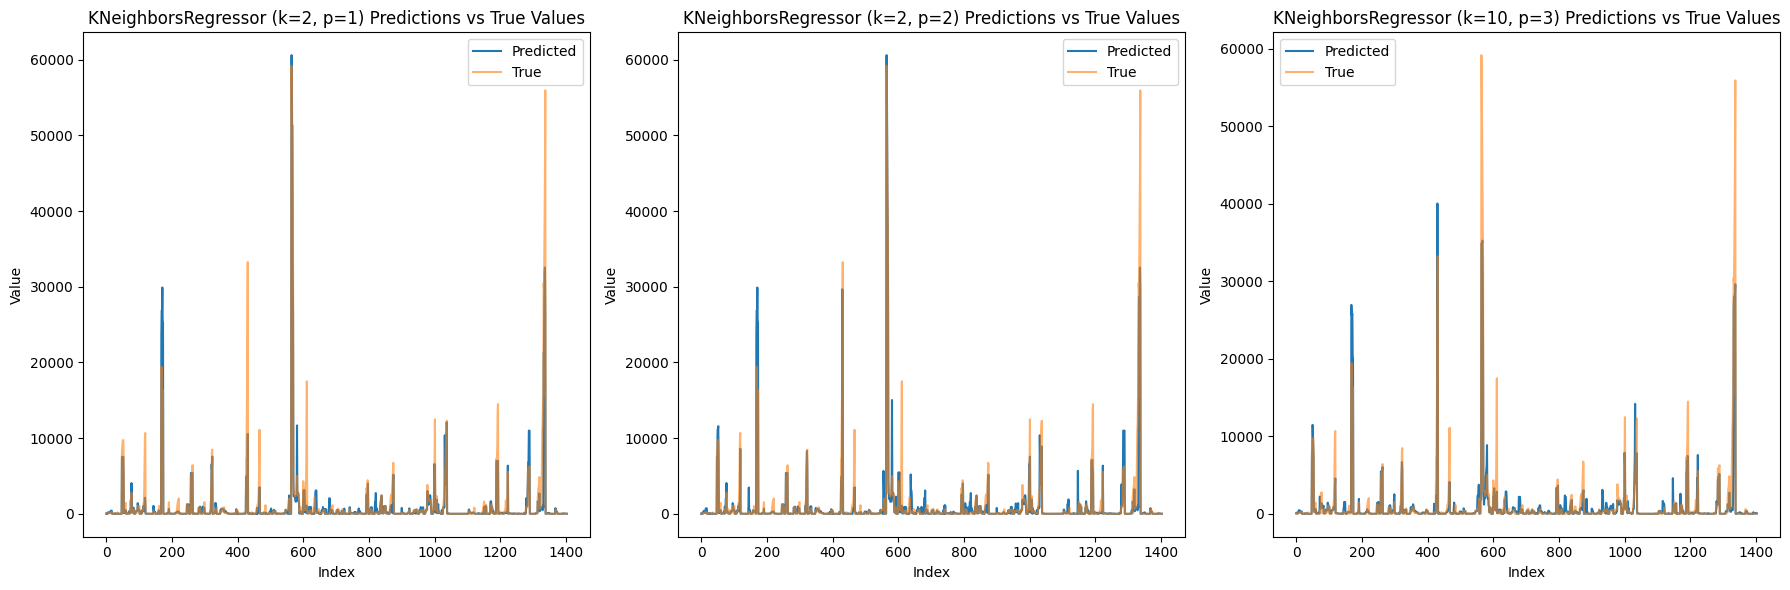

In [149]:
# Select three specific rows from tuning_data_df
rows_to_plot = [0, 4, 10]  # Adjust indices as needed to select different combinations of (k, p)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, row in enumerate(rows_to_plot):
    y_pred = tuning_data_df.loc[row, "y_pred"]
    k = tuning_data_df.loc[row, "k"]
    p = tuning_data_df.loc[row, "p"]
    y_test_rescaled = tuning_data_df.loc[row, "y_test_rescaled"]
    model_name = f"KNeighborsRegressor (k={k}, p={p})"
    print(f"for k={k} , p={p}: MAE = {tuning_data_df.loc[row, 'MAE']} , MSE = {tuning_data_df.loc[row, 'MSE']}")
    plot_model(y_pred, y_test_rescaled, model_name, axs[i])

plt.tight_layout()
plt.show()

## Polynomial

In [148]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR

Evaluating Polynomial Regression
MAE: 78.535258096883
MSE: 127.66563159899646
[ 46.35866253  29.7505649   52.43306981  63.11171417  78.64990597
  76.3988884  151.06348217 122.98655842 145.03991204 176.38187519]


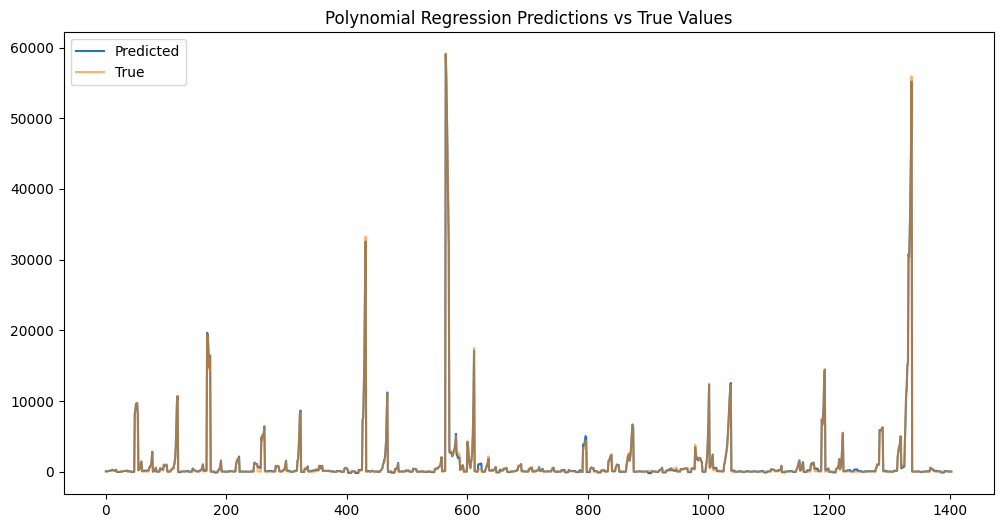

In [149]:
poly = PolynomialFeatures(degree=2)
X_poly_tr = poly.fit_transform(X_tr)
#X_poly_val = poly.transform(X_val)
X_poly_te = poly.transform(X_te)

linear_model = LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42)
#evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_val, y_val, min_max_scaler_Y, model_name="Polynomial Regression")
evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_te, y_te, min_max_scaler_Y, model_name="Polynomial Regression")

## AdaBoost

In [150]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

Evaluating AdaBoostRegressor
MAE: 2546.0747916946098
MSE: 3900.1011898066135
[2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148
 2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148]


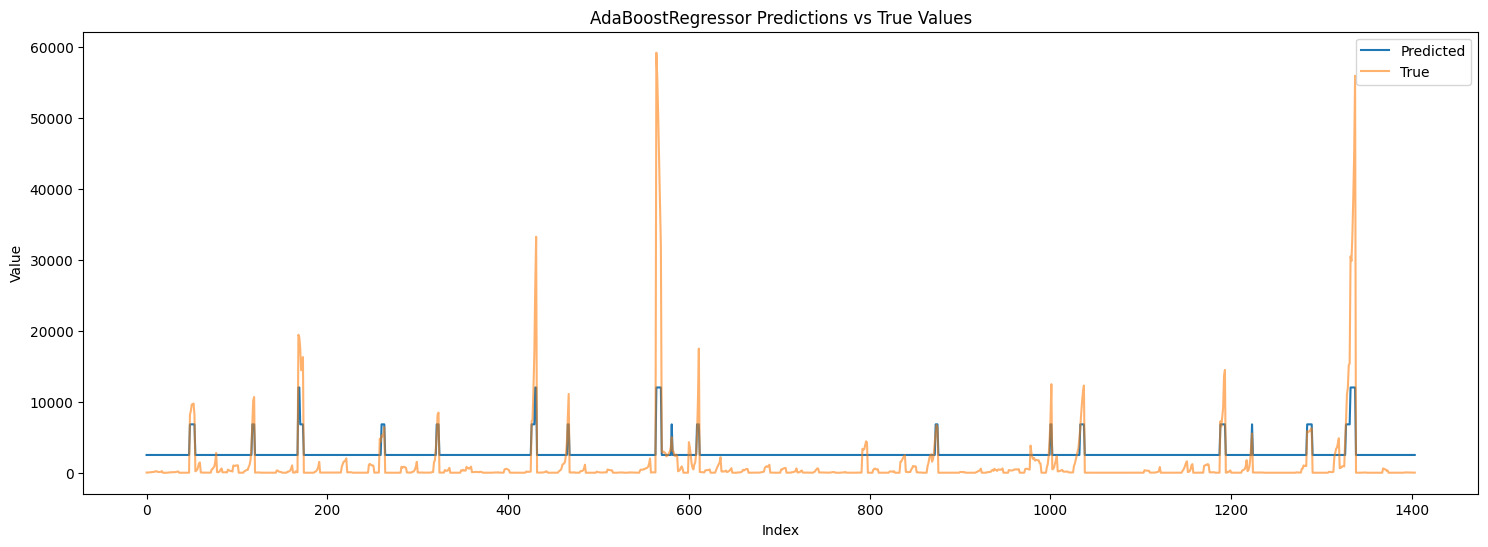

In [141]:
# Train and evaluate AdaBoostRegressor model
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="AdaBoostRegressor")

## Random Forest

In [152]:
from sklearn.ensemble import RandomForestRegressor

Evaluating RandomForestRegressor
MAE: 455.9947120995119
MSE: 751.0454963440693
[308.58380774 308.58380774 308.58380774 308.58380774 308.58380774
 308.58380774 308.58380774 308.58380774 308.58380774 308.58380774]


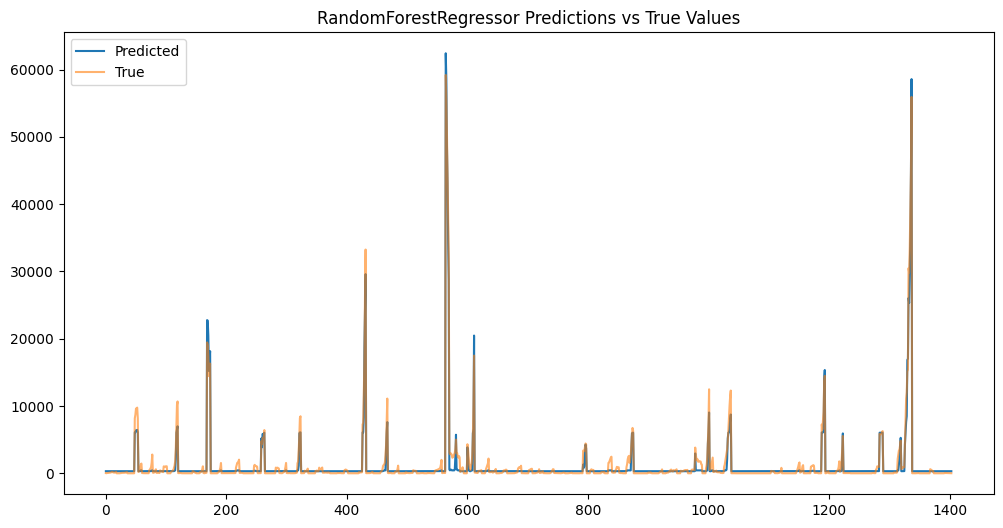

In [153]:
# Train and evaluate RandomForestRegressor model
regr = RandomForestRegressor(max_depth=4, random_state=0)
#evaluate_model(regr, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name="RandomForestRegressor")
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="RandomForestRegressor")

## Stacking

In [154]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

Evaluating StackingRegressor
MAE: 44.33629197846652
MSE: 147.0270767189279
[ 12.46419349  10.37419349  11.39572367  11.8045653   29.44572367
  69.09229715  97.44666667  66.628       55.15966667 122.03      ]


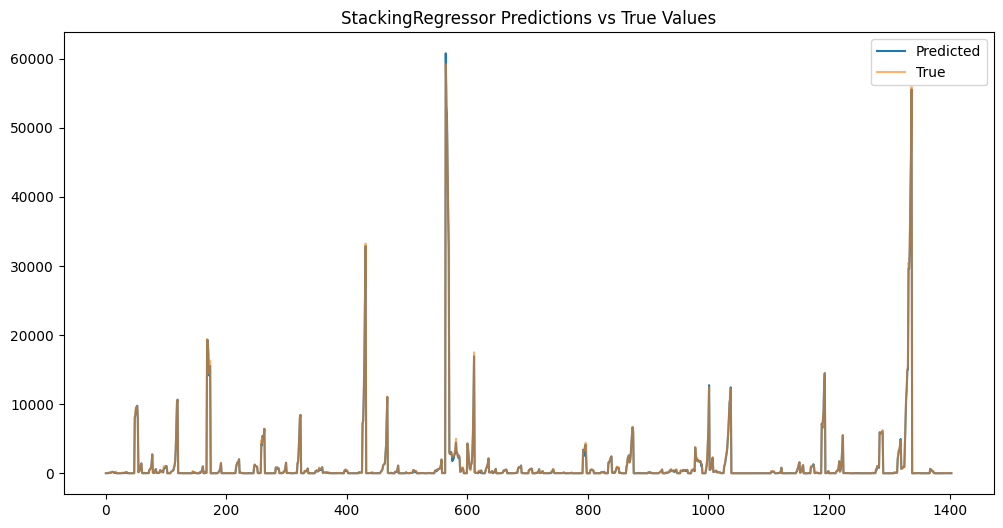

In [155]:
# Train and evaluate StackingRegressor model
estimators = [('lr', RidgeCV()), ('svr', LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42))]
reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))
#evaluate_model(reg, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name="StackingRegressor")
evaluate_model(reg, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="StackingRegressor")

In [156]:
#check to see if my rescaling is working as intended

# Test scaling and rescaling
sample_y = [y_scaled[0], y_scaled[10], y_scaled[100]]
print("Sample scaled values:", sample_y)

rescaled_y = rescale_data(min_max_scaler_Y, sample_y)
print("Rescaled values:", rescaled_y)

original_y = [Y_list[0], Y_list[10], Y_list[100]]
print("Original values:", original_y)

# Check if rescaled values match the original values
print("Match:", np.allclose(rescaled_y, original_y))

Sample scaled values: [array([0.]), array([4.20007403e-07]), array([4.44713721e-06])]
Rescaled values: [  0.  17. 180.]
Original values: [0.0, 17.0, 180.0]
Match: True


# TEST

In [157]:
# ns_list, train_scores, validation_scores = learning_curve(
#                                                    estimator = SVR(**opt_svr_param), 
#                                                    X = X, y = Y, 
#                                                    train_sizes = ns_list, cv = 5,
#                                                    scoring = 'neg_mean_squared_error')


In [158]:
# train_scores, valid_scores = validation_curve(KNeighborsRegressor(), X, Y, 
#                                               param_name="n_neighbors",
#                                               param_range=k_list , cv=20, 
#                                               scoring = 'neg_mean_squared_error',
#                                               verbose=1, n_jobs=-1
#                                              )
